# FTE/BTE Experiment for food-101

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, a representation ensembling algorithm based on decision forests (Lifelong Forest) demonstrate forward and backward knowledge transfer of tasks on the food-101 dataset. The experiment reproduces the benchmarking adversarial experiment ran in the paper "A General Approach to Progressive Learning" by Vogelstein, et al (2020). The following is a link to the aforementioned paper: https://arxiv.org/pdf/2004.12908.pdf  

### Import necessary packages and modules

In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from joblib import Parallel, delayed
from itertools import product

### Load food-101 data - UPDATE THIS
We load the food-101 dataset from Keras, and store it in a variable. The training and test partitions are concatenated into one variable called `data_x`. The data is obtained from .

In [2]:
# load dict of arrays
dict_data_x = np.load('food_101_array_data_x.npz')
# extract the first array
data_x = dict_data_x['arr_0']
# print the array shape
print(data_x.shape)

(100000, 32, 32, 3)


In [3]:
# load dict of arrays
dict_data_y = np.load('food_101_array_data_y.npz')
# extract the first array
data_y = dict_data_y['arr_0']
# print the array shape
print(data_y.shape)

(100000,)


### Define hyperparameters for the model and preprocess data
Running the cells below will define the hyperparameters the experimental setting 

`num_points_per_task`: The number of points per task 

In [4]:
num_points_per_task = 900

### Train the model and perform validation

#### run_parallel_exp: 
Wrapper method for the `LF_experiment` function which declares and trains the model, and performs validation with respect to the test data to compute the error of the model at a particular iteration

In [5]:
from functions.fte_bte_food_101_functions_slots import run_bte_exp

def run_parallel_exp(slot):
    
    df_list = run_bte_exp(data_x, data_y, num_points_per_task, slot = slot)
    
    return df_list

In [6]:
slots = np.arange(0,10,1)
acc = []

with Pool(8) as p:
    # Multiple sets of errors for each set of angles are appended to a larger array containing errors for all angles
    # Calling LF_experiment will run the experiment at a new angle of rotation
    acc.append(
        p.map(run_parallel_exp, slots)
    )

Starting Task 0 For Slot 5
Starting Task 0 For Slot 4
Starting Task 0 For Slot 1
Starting Task 0 For Slot 0
Starting Task 0 For Slot 2
Starting Task 0 For Slot 6
Starting Task 0 For Slot 7
Starting Task 0 For Slot 3
Accuracy Across Tasks: [0.236]
Starting Task 1 For Slot 4
Accuracy Across Tasks: [0.246]
Starting Task 1 For Slot 3
Accuracy Across Tasks: [0.242]
Starting Task 1 For Slot 6
Accuracy Across Tasks: [0.235]
Starting Task 1 For Slot 7
Accuracy Across Tasks: [0.235]
Starting Task 1 For Slot 5
Accuracy Across Tasks: [0.212]
Starting Task 1 For Slot 2
Accuracy Across Tasks: [0.24]
Starting Task 1 For Slot 1
Accuracy Across Tasks: [0.257]
Starting Task 1 For Slot 0
Accuracy Across Tasks: [0.24, 0.25]
Starting Task 2 For Slot 1
Accuracy Across Tasks: [0.235, 0.25]
Starting Task 2 For Slot 5
Accuracy Across Tasks: [0.212, 0.229]
Starting Task 2 For Slot 2
Accuracy Across Tasks: [0.236, 0.254]
Starting Task 2 For Slot 4
Accuracy Across Tasks: [0.235, 0.257]
Starting Task 2 For Slot 7

In [22]:
acc_x = []
acc_y = []
for y in range(10):
    for x in range(10):
        acc_x.append(acc[0][x]['task_1_accuracy'][y])
    acc_y.append(np.mean(acc_x))
    acc_x = []
print(acc_y)

[0.2367, 0.2524, 0.2616, 0.26230000000000003, 0.265, 0.26680000000000004, 0.26870000000000005, 0.27009999999999995, 0.27090000000000003, 0.2717]


### Function to calculate backward transfer efficiency

The backward transfer efficiency of $f_n$ for task $t$ given $n$ samples is 
$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

We say an algorithm achieves backward transfer for task $t$ if and only if $BTE^t(f_n) > 1$. Intuitively, this means that the progressive learner has used data associated with new tasks to improve performance on previous tasks. 

#### calc_bte:
Function used to calculate bte across tasks, averaged across all shifts and folds

In [23]:
#from functions.fte_bte_food_101_functions_slots import calc_bte

#btes = calc_bte(df_list, 1, 1)
#btes = df_list["task_1_accuracy"]/df_list["task_1_accuracy"][0]
btes = acc_y/acc_y[0]
print(btes)

[1.         1.06632869 1.10519645 1.10815378 1.11956063 1.12716519
 1.13519223 1.14110689 1.14448669 1.1478665 ]


### Plotting the backward transfer efficiency
Run cell to generate plot of backward transfer efficiency of the Lifelong Classification Forest algorithm. We see that we achieve backwards transfer overall that increases as more tasks are seen.

#### plot_bte:
Function used to plot bte across tasks

In [ ]:
from functions.fte_bte_food_101_functions_slots import plot_bte

plot_bte(btes)

In [24]:
import seaborn as sns

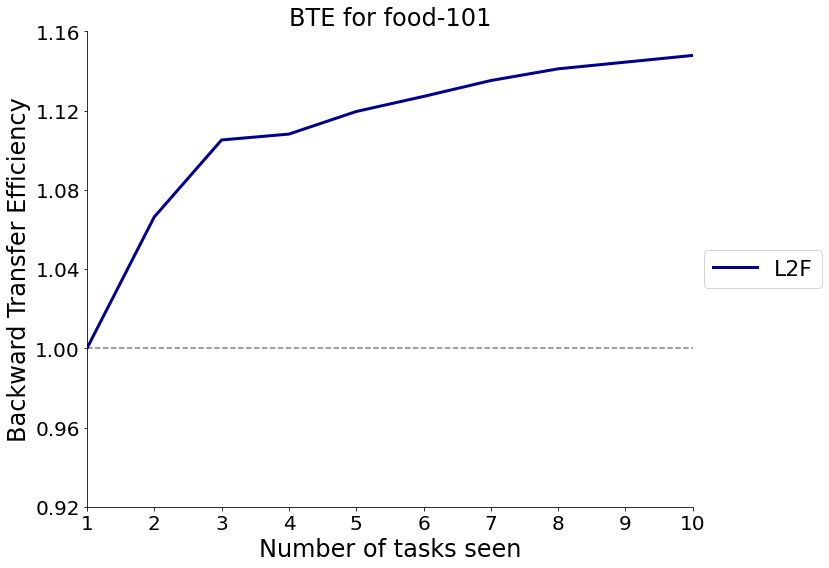

In [25]:
clr = ["#00008B"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the results
ax.plot(np.arange(1, 11), btes, c=c[0], label="L2F", linewidth=3)

# Format the plot, and show result
plt.ylim(0.92, 1.16)
plt.xlim(1, 10)
ax.set_yticks([0.92, 0.96, 1, 1.04, 1.08, 1.12, 1.16])
ax.yaxis.set_ticks([0.92, 0.96, 1, 1.04, 1.08, 1.12, 1.16])
ax.set_xticks(np.arange(1, 11))
ax.tick_params(labelsize=20)
ax.set_xlabel("Number of tasks seen", fontsize=24)
ax.set_ylabel("Backward Transfer Efficiency", fontsize=24)
ax.set_title("BTE for food-101", fontsize=24)
ax.hlines(1, 1, 10, colors="grey", linestyles="dashed", linewidth=1.5)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=22)
plt.show()